In [61]:
# 1. Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve)

In [62]:
# 2. Loading the dataset

df = pd.read_csv(r'C:\Users\Welcome\Desktop\Python Coding Projects\Rain Prediction\weatherAUS.csv')

print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [63]:
# 3. Handling missing values

for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        if df[col].skew() > 1:
            df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].mean(), inplace=True)

In [64]:
# 4. Feature Engineering

df['TempDiff'] = df['Temp3pm'] - df['Temp9am']
df['HumidityDiff'] = df['Humidity3pm'] - df['Humidity9am']
df['WindSpeedDiff'] = df['WindSpeed3pm'] - df['WindSpeed9am']
df['PressureDiff'] = df['Pressure3pm'] - df['Pressure9am']

In [65]:
df.select_dtypes(include='object').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Date          145460 non-null  object
 1   Location      145460 non-null  object
 2   WindGustDir   145460 non-null  object
 3   WindDir9am    145460 non-null  object
 4   WindDir3pm    145460 non-null  object
 5   RainToday     145460 non-null  object
 6   RainTomorrow  145460 non-null  object
dtypes: object(7)
memory usage: 7.8+ MB


In [66]:
# 5. Encoding Categorical Variables

categorical_cols = ['WindGustDir','WindDir9am','WindDir3pm','RainToday']

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


In [67]:
# 5b. Encoding the target variable within the same column

le = LabelEncoder()

df['RainTomorrow'] = le.fit_transform(df['RainTomorrow'])

In [68]:
# 6. Train Test Split

X = df.drop(columns=['Date','Location','RainTomorrow'])
y = df['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [69]:
# 7. Model Training

rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [70]:
# 8. Evaluation

y_pred = rf.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Classification Report:\n ', classification_report(y_test, y_pred))
print('Confusion Matrix:\n ', confusion_matrix(y_test, y_pred))


Accuracy:  0.8571428571428571
Classification Report:
                precision    recall  f1-score   support

           0       0.87      0.96      0.91     22717
           1       0.77      0.50      0.60      6375

    accuracy                           0.86     29092
   macro avg       0.82      0.73      0.76     29092
weighted avg       0.85      0.86      0.85     29092

Confusion Matrix:
  [[21754   963]
 [ 3193  3182]]


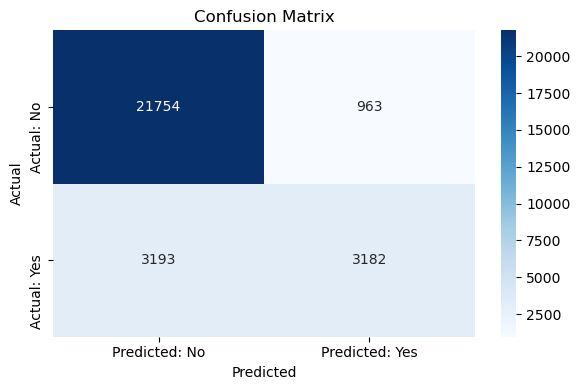

In [71]:
# 8b. Confusion matrix chart

cm = confusion_matrix(y_test,y_pred)

plt.figure(figsize = (6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar='False',
           xticklabels=['Predicted: No','Predicted: Yes'],
           yticklabels=['Actual: No','Actual: Yes'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [72]:
# 8c. ROC AUC

y_proba = rf.predict_proba(X_test)[:,1]
print('ROC AUC Score: ', roc_auc_score(y_test,y_proba))

ROC AUC Score:  0.8821768098003827


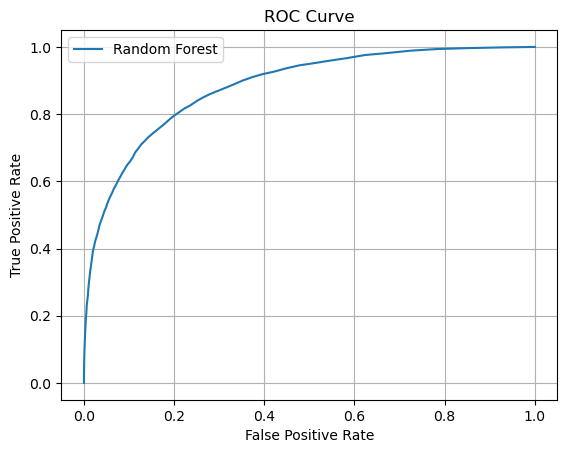

In [73]:
# 9. Plotting ROC Curve

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

In [74]:
# 10. Cross Validation

cv_scores = cross_val_score(rf, X, y, cv=5, scoring='accuracy')
print('Cross validation Accuracy: ', np.mean(cv_scores))

Cross validation Accuracy:  0.8446720747971952


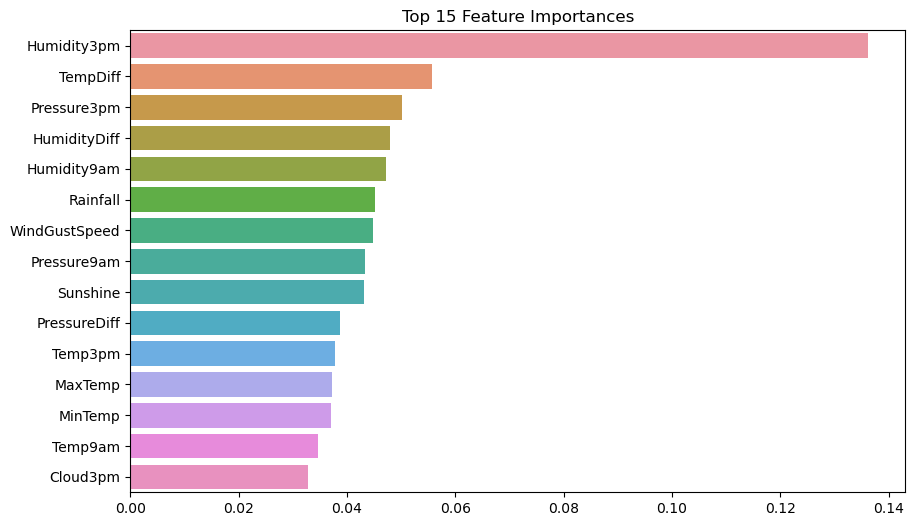

In [75]:
# 11. Feature Importance

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=importances[:15],y=importances.index[:15])
plt.title('Top 15 Feature Importances')
plt.show()

In [76]:
# 12. Hyperparameter Tuning

param_grid = {
    'n_estimators': [100,200],
    'max_depth': [10,20,None],
    'min_samples_split': [2,5],
    'max_features': ['sqrt','log2']
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy')
grid.fit(X_train, y_train)
print('Best Parameters: ', grid.best_params_)
best_rf = grid.best_estimator_
print('Best Accuracy on Test Set: ', accuracy_score(y_test, best_rf.predict(X_test)))


Best Parameters:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200}
Best Accuracy on Test Set:  0.8573490994087721


Accuracy:  0.8573490994087721
Classification Report:
                precision    recall  f1-score   support

           0       0.87      0.96      0.91     22717
           1       0.76      0.50      0.61      6375

    accuracy                           0.86     29092
   macro avg       0.82      0.73      0.76     29092
weighted avg       0.85      0.86      0.85     29092



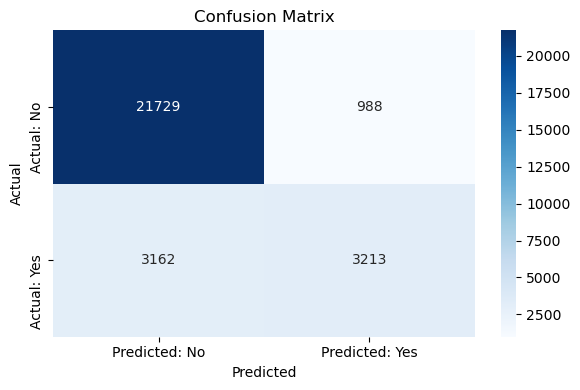

In [77]:
# 13. Evaluating best_rf

y_pred = best_rf.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Classification Report:\n ', classification_report(y_test, y_pred))

cm = confusion_matrix(y_test,y_pred)

plt.figure(figsize = (6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar='False',
           xticklabels=['Predicted: No','Predicted: Yes'],
           yticklabels=['Actual: No','Actual: Yes'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()